# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [8]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [9]:
asl.df['left-x-mean'] = asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [10]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()
# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [11]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']
features_org = ['right-x','right-y', 'left-x', 'left-y']

# zip both lists together so we can iterate as tuples
norm_org_fields = zip(features_norm, features_org)

for norm, org in norm_org_fields:
    # standard score (z score) = (X - μ) / σ
    # norm = (original value - mean) / standard deviation
    
    # calculate mean
    asl.df[f'{org}-mean'] = asl.df['speaker'].map(df_means[org])
    
    # calculate standard deviation
    asl.df[f'{org}-std']= asl.df['speaker'].map(df_std[org])
    
    # calculate standard score
    asl.df[norm] = (asl.df[org] - asl.df[f'{org}-mean']) / asl.df[f'{org}-std']
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly    ...     right-x-std   norm-rx  \
video frame                               ...                             
98    0          113        9      119    ...       16.459943  1.153232   
      1          113        9      119    ...       16.459943  1.153232   
      2          113        9      119    ...       16.459943  1.153232   
      3          113        9      119    ...       16.459943  1.153232   
      4          113        9      119    ...       16.459943  1.153232   

             right-y-mean  right-y-std   norm-ry  left-x-std   norm-lx  \
video frame                                                              
98    0        117.332462    34.667787  1.663433   17.573442 -0.891199   
      1        117.332462    34.667787  1.663433   17.573442 -0.891199   
      2        117.332462    34.667787  1.663433   17.573442 -0.891199   
      3        117.332462    34.667787  1.663433   17.573442 -0.891199   
      4        117.332462    34.667787  1.663433   17.573442 -0.891199   

             left-y-mean  left-y-std   norm-ly  
video frame                                     
98    0       161.271242   26.594521  0.741835  
      1       161.271242   26.594521  0.741835  
      2       161.271242   26.594521  0.741835  
      3       161.271242   26.594521  0.741835  
      4       161.271242   26.594521  0.741835  

[5 rows x 23 columns]

In [12]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
features_polar_group = [[features_polar[0], features_polar[1]], [features_polar[2], features_polar[3]]]
features_org = [['grnd-rx','grnd-ry'], ['grnd-lx', 'grnd-ly']]

features_polar_delta = ['polar-rr-delta', 'polar-rtheta-delta', 'polar-lr-delta', 'polar-ltheta-delta']

# zip both lists together so we can iterate as array of tuples
polar_org_fields = zip(features_polar_group, features_org)

for polar, org in polar_org_fields:
    # convert cartesian coordinates x, y into polar r, ϕ
    r, phi = polar
    x, y = org
    
    # calculate radius r with 🐍agoras's theorem
    # r = sqrt(x^2 + y^2)
    asl.df[r] = (asl.df[x] ** 2 + asl.df[y] ** 2) ** 0.5
    
    # calculate ϕ angle arctan2
    # ϕ = atan2(y, x)
    # we will swap y and x to give a different quadrant
    asl.df[phi] = np.arctan2(asl.df[x], asl.df[y])
    
    # calculate delta while we are here
    asl.df[f'{r}-delta'] = asl.df[r].diff(periods=1)
    asl.df[f'{phi}-delta'] = asl.df[phi].diff(periods=1)
    asl.df = asl.df.fillna(value=0)
    
asl.df.head()
    

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly         ...          left-y-std  \
video frame                                    ...                       
98    0          113        9      119         ...           26.594521   
      1          113        9      119         ...           26.594521   
      2          113        9      119         ...           26.594521   
      3          113        9      119         ...           26.594521   
      4          113        9      119         ...           26.594521   

              norm-ly   polar-rr  polar-rtheta  polar-rr-delta  \
video frame                                                      
98    0      0.741835  113.35784      0.079478             0.0   
      1      0.741835  113.35784      0.079478             0.0   
      2      0.741835  113.35784      0.079478             0.0   
      3      0.741835  113.35784      0.079478             0.0   
      4      0.741835  113.35784      0.079478             0.0   

             polar-rtheta-delta    polar-lr  polar-ltheta  polar-lr-delta  \
video frame                                                                 
98    0                     0.0  119.603512     -0.100501             0.0   
      1                     0.0  119.603512     -0.100501             0.0   
      2                     0.0  119.603512     -0.100501             0.0   
      3                     0.0  119.603512     -0.100501             0.0   
      4                     0.0  119.603512     -0.100501             0.0   

             polar-ltheta-delta  
video frame                      
98    0                     0.0  
      1                     0.0  
      2                     0.0  
      3                     0.0  
      4                     0.0  

[5 rows x 31 columns]

In [13]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']
features_org = ['grnd-rx','grnd-ry', 'grnd-lx', 'grnd-ly']

# zip both lists together so we can iterate as array of tuples
delta_org_fields = zip(features_delta, features_org)

for delta, org in delta_org_fields:
    # get the difference with the previous time period
    asl.df[delta] = asl.df[org].diff(periods=1)
    asl.df = asl.df.fillna(value=0)
    
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly    ...     polar-rr-delta  \
video frame                               ...                      
98    0          113        9      119    ...                0.0   
      1          113        9      119    ...                0.0   
      2          113        9      119    ...                0.0   
      3          113        9      119    ...                0.0   
      4          113        9      119    ...                0.0   

             polar-rtheta-delta    polar-lr  polar-ltheta  polar-lr-delta  \
video frame                                                                 
98    0                     0.0  119.603512     -0.100501             0.0   
      1                     0.0  119.603512     -0.100501             0.0   
      2                     0.0  119.603512     -0.100501             0.0   
      3                     0.0  119.603512     -0.100501             0.0   
      4                     0.0  119.603512     -0.100501             0.0   

             polar-ltheta-delta  delta-rx  delta-ry  delta-lx  delta-ly  
video frame                                                              
98    0                     0.0       0.0       0.0       0.0       0.0  
      1                     0.0       0.0       0.0       0.0       0.0  
      2                     0.0       0.0       0.0       0.0       0.0  
      3                     0.0       0.0       0.0       0.0       0.0  
      4                     0.0       0.0       0.0       0.0       0.0  

[5 rows x 35 columns]

In [14]:
# normalize using a feature scaling equation

features_scale = ['scale-rx', 'scale-ry', 'scale-lx','scale-ly']
features_org = ['right-x','right-y', 'left-x', 'left-y']
#features_org = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']

# zip both lists together so we can iterate as tuples
scale_org_fields = zip(features_scale, features_org)

df_max = asl.df.groupby('speaker').max()
df_min = asl.df.groupby('speaker').min()

for scale, org in scale_org_fields:    
    # min
    asl.df[f'{org}-min'] = asl.df['speaker'].map(df_min[org])

    # max
    asl.df[f'{org}-max'] = asl.df['speaker'].map(df_max[org])
    
    # rescale formula
    # x' = (x - min(x)) / max(x) - min(x)
    asl.df[scale] = (asl.df[org] - asl.df[f'{org}-min']) / (asl.df[f'{org}-max'] - asl.df[f'{org}-min'])
    
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly    ...     scale-rx  right-y-min  \
video frame                               ...                             
98    0          113        9      119    ...      0.66087           37   
      1          113        9      119    ...      0.66087           37   
      2          113        9      119    ...      0.66087           37   
      3          113        9      119    ...      0.66087           37   
      4          113        9      119    ...      0.66087           37   

             right-y-max  scale-ry  left-x-min  left-x-max  scale-lx  \
video frame                                                            
98    0              179  0.971831         139         235  0.104167   
      1              179  0.971831         139         235  0.104167   
      2              179  0.971831         139         235  0.104167   
      3              179  0.971831         139         235  0.104167   
      4              179  0.971831         139         235  0.104167   

             left-y-min  left-y-max  scale-ly  
video frame                                    
98    0              84         191  0.906542  
      1              84         191  0.906542  
      2              84         191  0.906542  
      3              84         191  0.906542  
      4              84         191  0.906542  

[5 rows x 47 columns]

In [15]:
# normalize the polar coordinates
features_polar_norm = ['polar-rr-norm', 'polar-rtheta-norm', 'polar-lr-norm', 'polar-ltheta-norm']
features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

df_polar_means = asl.df.groupby('speaker').mean()
df_polar_std = asl.df.groupby('speaker').std()

# zip both lists together so we can iterate as tuples
polar_norm_fields = zip(features_polar_norm, features_polar)

for polar_norm, polar in polar_norm_fields:
    # standard score (z score) = (X - μ) / σ
    # norm = (original value - mean) / standard deviation
    
    # calculate mean
    asl.df[f'{polar}-mean'] = asl.df['speaker'].map(df_polar_means[polar])
    
    # calculate standard deviation
    asl.df[f'{polar}-std']= asl.df['speaker'].map(df_polar_std[polar])
    
    # calculate standard score
    asl.df[polar_norm] = (asl.df[polar] - asl.df[f'{polar}-mean']) / asl.df[f'{polar}-std']
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly        ...          polar-rr-norm  \
video frame                                   ...                          
98    0          113        9      119        ...               1.573439   
      1          113        9      119        ...               1.573439   
      2          113        9      119        ...               1.573439   
      3          113        9      119        ...               1.573439   
      4          113        9      119        ...               1.573439   

             polar-rtheta-mean  polar-rtheta-std  polar-rtheta-norm  \
video frame                                                           
98    0              -0.302214          0.397837           0.959419   
      1              -0.302214          0.397837           0.959419   
      2              -0.302214          0.397837           0.959419   
      3              -0.302214          0.397837           0.959419   
      4              -0.302214          0.397837           0.959419   

             polar-lr-mean  polar-lr-std  polar-lr-norm  polar-ltheta-mean  \
video frame                                                                  
98    0         105.968447     25.133829       0.542499           0.060601   
      1         105.968447     25.133829       0.542499           0.060601   
      2         105.968447     25.133829       0.542499           0.060601   
      3         105.968447     25.133829       0.542499           0.060601   
      4         105.968447     25.133829       0.542499           0.060601   

             polar-ltheta-std  polar-ltheta-norm  
video frame                                       
98    0              0.219121          -0.735219  
      1              0.219121          -0.735219  
      2              0.219121          -0.735219  
      3              0.219121          -0.735219  
      4              0.219121          -0.735219  

[5 rows x 59 columns]

In [16]:
# scale the polar coordinates
features_polar_scale = ['polar-rr-scale', 'polar-rtheta-scale', 'polar-lr-scale', 'polar-ltheta-scale']
features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

# zip both lists together so we can iterate as tuples
polar_scale_fields = zip(features_polar_scale, features_polar)

df_max = asl.df.groupby('speaker').max()
df_min = asl.df.groupby('speaker').min()

for scale, polar in polar_scale_fields:    
    # min
    asl.df[f'{polar}-min'] = asl.df['speaker'].map(df_min[polar])

    # max
    asl.df[f'{polar}-max'] = asl.df['speaker'].map(df_max[polar])
    
    # rescale formulae
    # x' = (x - min(x)) / max(x) - min(x)
    asl.df[scale] = (asl.df[polar] - asl.df[f'{polar}-min']) / (asl.df[f'{polar}-max'] - asl.df[f'{polar}-min'])
    
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly         ...          polar-rr-scale  \
video frame                                    ...                           
98    0          113        9      119         ...                0.894177   
      1          113        9      119         ...                0.894177   
      2          113        9      119         ...                0.894177   
      3          113        9      119         ...                0.894177   
      4          113        9      119         ...                0.894177   

             polar-rtheta-min  polar-rtheta-max  polar-rtheta-scale  \
video frame                                                           
98    0             -2.498092          1.125495            0.711331   
      1             -2.498092          1.125495            0.711331   
      2             -2.498092          1.125495            0.711331   
      3             -2.498092          1.125495            0.711331   
      4             -2.498092          1.125495            0.711331   

             polar-lr-min  polar-lr-max  polar-lr-scale  polar-ltheta-min  \
video frame                                                                 
98    0         35.777088     138.75518        0.814022         -0.198946   
      1         35.777088     138.75518        0.814022         -0.198946   
      2         35.777088     138.75518        0.814022         -0.198946   
      3         35.777088     138.75518        0.814022         -0.198946   
      4         35.777088     138.75518        0.814022         -0.198946   

             polar-ltheta-max  polar-ltheta-scale  
video frame                                        
98    0              1.153898            0.072769  
      1              1.153898            0.072769  
      2              1.153898            0.072769  
      3              1.153898            0.072769  
      4              1.153898            0.072769  

[5 rows x 71 columns]

In [17]:
# adding additional deltas

features_delta_scale = ['scale-rx-delta', 'scale-ry-delta', 'scale-lx-delta','scale-ly-delta']
features_scale = ['scale-rx', 'scale-ry', 'scale-lx','scale-ly']

# zip both lists together so we can iterate as array of tuples
delta_scale_fields = zip(features_delta_scale, features_scale)

for delta, scale in delta_scale_fields:
    # get the difference with the previous time period
    asl.df[delta] = asl.df[scale].diff(periods=1)
    asl.df = asl.df.fillna(value=0)
    
asl.df.tail()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
125   52        148     181      171      156     162      60  woman-1   
      53        148     181      172      165     162      60  woman-1   
      54        148     181      175      173     162      60  woman-1   
      55        148     181      175      173     162      60  woman-1   
      56        148     181      175      173     162      60  woman-1   

             grnd-ry  grnd-rx  grnd-ly       ...        polar-lr-min  \
video frame                                  ...                       
125   52          96        9      121       ...           35.777088   
      53         105       10      121       ...           35.777088   
      54         113       13      121       ...           35.777088   
      55         113       13      121       ...           35.777088   
      56         113       13      121       ...           35.777088   

             polar-lr-max  polar-lr-scale  polar-ltheta-min  polar-ltheta-max  \
video frame                                                                     
125   52        138.75518        0.835422         -0.198946          1.153898   
      53        138.75518        0.835422         -0.198946          1.153898   
      54        138.75518        0.835422         -0.198946          1.153898   
      55        138.75518        0.835422         -0.198946          1.153898   
      56        138.75518        0.835422         -0.198946          1.153898   

             polar-ltheta-scale  scale-rx-delta  scale-ry-delta  \
video frame                                                       
125   52               0.061911        0.017391        0.063380   
      53               0.061911        0.008696        0.063380   
      54               0.061911        0.026087        0.056338   
      55               0.061911        0.000000        0.000000   
      56               0.061911        0.000000        0.000000   

             scale-lx-delta  scale-ly-delta  
video frame                                  
125   52                0.0             0.0  
      53                0.0             0.0  
      54                0.0             0.0  
      55                0.0             0.0  
      56                0.0             0.0  

[5 rows x 75 columns]

In [18]:
# left and right diff on x and y polar
features_polar_scale_diff = ['polar-r-diff', 'polar-theta-diff']
features_polar_scale = [['polar-rr-scale', 'polar-lr-scale'], ['polar-rtheta-scale', 'polar-ltheta-scale']]

features_polar_scale_diff_delta = ['polar-r-diff-delta', 'polar-theta-diff-delta']

# zip both lists together so we can iterate as tuples
polar_scale_diff_fields = zip(features_polar_scale_diff, features_polar_scale)

for diff, polar in polar_scale_diff_fields:
    polar_r, polar_l = polar
    asl.df[diff] = np.absolute(asl.df[polar_r] - asl.df[polar_l])
    asl.df[f'{diff}-delta'] = asl.df[diff].diff(periods=1)
    asl.df = asl.df.fillna(value=0)

asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly           ...            \
video frame                                      ...             
98    0          113        9      119           ...             
      1          113        9      119           ...             
      2          113        9      119           ...             
      3          113        9      119           ...             
      4          113        9      119           ...             

             polar-ltheta-max  polar-ltheta-scale  scale-rx-delta  \
video frame                                                         
98    0              1.153898            0.072769             0.0   
      1              1.153898            0.072769             0.0   
      2              1.153898            0.072769             0.0   
      3              1.153898            0.072769             0.0   
      4              1.153898            0.072769             0.0   

             scale-ry-delta  scale-lx-delta  scale-ly-delta  polar-r-diff  \
video frame                                                                 
98    0                 0.0             0.0             0.0      0.080155   
      1                 0.0             0.0             0.0      0.080155   
      2                 0.0             0.0             0.0      0.080155   
      3                 0.0             0.0             0.0      0.080155   
      4                 0.0             0.0             0.0      0.080155   

             polar-r-diff-delta  polar-theta-diff  polar-theta-diff-delta  
video frame                                                                
98    0                     0.0          0.638562                     0.0  
      1                     0.0          0.638562                     0.0  
      2                     0.0          0.638562                     0.0  
      3                     0.0          0.638562                     0.0  
      4                     0.0          0.638562                     0.0  

[5 rows x 79 columns]

In [19]:
# left and right diff on x and y ground
features_ground_diff = ['grnd-x-diff', 'grnd-y-diff']
features_org = [['grnd-rx','grnd-lx'], ['grnd-ry', 'grnd-ly']]

features_ground_diff_delta = ['grnd-x-diff-delta', 'grnd-y-diff-delta']

# zip both lists together so we can iterate as tuples
ground_diff_fields = zip(features_ground_diff, features_org)

for diff, ground in ground_diff_fields:
    ground_r, ground_l = ground
    asl.df[diff] = np.absolute(asl.df[ground_r] - asl.df[ground_l])
    asl.df[f'{diff}-delta'] = asl.df[diff].diff(periods=1)
    asl.df = asl.df.fillna(value=0)

asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly        ...          scale-lx-delta  \
video frame                                   ...                           
98    0          113        9      119        ...                     0.0   
      1          113        9      119        ...                     0.0   
      2          113        9      119        ...                     0.0   
      3          113        9      119        ...                     0.0   
      4          113        9      119        ...                     0.0   

             scale-ly-delta  polar-r-diff  polar-r-diff-delta  \
video frame                                                     
98    0                 0.0      0.080155                 0.0   
      1                 0.0      0.080155                 0.0   
      2                 0.0      0.080155                 0.0   
      3                 0.0      0.080155                 0.0   
      4                 0.0      0.080155                 0.0   

             polar-theta-diff  polar-theta-diff-delta  grnd-x-diff  \
video frame                                                          
98    0              0.638562                     0.0           21   
      1              0.638562                     0.0           21   
      2              0.638562                     0.0           21   
      3              0.638562                     0.0           21   
      4              0.638562                     0.0           21   

             grnd-x-diff-delta  grnd-y-diff  grnd-y-diff-delta  
video frame                                                     
98    0                    0.0            6                0.0  
      1                    0.0            6                0.0  
      2                    0.0            6                0.0  
      3                    0.0            6                0.0  
      4                    0.0            6                0.0  

[5 rows x 83 columns]

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**

I implemented a mix of normalize with the scaling equation, delta and diffing of existing features.

The features_scale uses the scaling equation on the original right and left, x and y.
The idea being that scaling reduces the difference and variation between similar patterns which hopefully would result in better recognition.

The features_delta_scale is the delta diff of the previous frame for the features_scale.
The purpose of the delta is to take advantage of the time dimensional information and detect acceleration and deceleration.

The features_polar_scale is the scaling equation applied to the polar features.
As above the idea being to reduce the sensitivity / variation between different data for the same words.

The features_polar_norm uses the z score to normalize the the polar features.
Unlike with the scaling, we are aiming to highlight the variation in terms of the relationship between the mean and the deviation from the mean.

The features_polar_scale_diff is the diff between the left and right polar features.
The idea here was to take advantage of the fact that some words use both hands and some do not, meaning that there should be unique information on how much the two hands vary from each other.

The features_polar_scale_diff_delta is the delta diff of the previous frame.
As above this is the time delta one step backwards for the polar scale diff.

The features_ground_diff is the left and right diff of the ground values for x and y.
As above this is a diff of the left and right hands in x and y from the ground values which are based on the diff between nose and each hand.

The features_ground_diff_delta is the previous frame delta.
Additionally the time step delta for the above feature was created.

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [20]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.013s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [21]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433187


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [22]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]
hidden state #1
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]
hidden state #2
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]


##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [23]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))
model, logL = train_a_word(my_testword, 5, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))
model, logL = train_a_word(my_testword, 10, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [   0.58333333   87.91666667   12.75        108.5       ]
variance =  [  39.41055556   18.74388889    9.855       144.4175    ]
hidden state #1
mean =  [ -9.30211403  55.32333876   6.92259936  71.24057775]
variance =  [ 16.16920957  46.50917372   3.81388185  15.79446427]
hidden state #2
mean =  [ -5.40587658  60.1652424    2.32479599  91.3095432 ]
variance =  [   7.95073876   64.13103127   13.68077479  129.5912395 ]
logL = -601.3291470028636
Number of states trained in model for CHOCOLATE is 5
hidden state #0
mean =  [ -9.23826304  55.30740641   6.92298855  71.30558162]
variance =  [ 16.30897315  45.96991798   3.76848558  15.98402053]
hidden state #1
mean =  [   3.32089022   86.11784619   12.66977977  102.36987409]
variance =  [ 12.48273231   7.43528515  12.86407411  24.73804616]
hidden state #2
mean =  [  -6.37753172   51.09767101    3.64019095  104.46455217]
variance =  [  10.28279876   12.43850367   27.3378

In [24]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_norm) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))
model, logL = train_a_word(my_testword, 5, features_norm) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))
model, logL = train_a_word(my_testword, 10, features_norm) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ 1.0625066  -0.1740204  -1.31812255 -1.61791893]
variance =  [ 0.05296979  0.00373254  0.03820247  0.05531266]
hidden state #1
mean =  [ 0.53813142 -0.04704542  0.04545    -0.61902479]
variance =  [ 0.02432711  0.04933945  0.03044391  0.13395751]
hidden state #2
mean =  [ 0.38934967 -0.18383814 -0.34623283 -1.59201968]
variance =  [ 0.0697732   0.02960059  0.07727065  0.06911305]
logL = 22.651977224475385
Number of states trained in model for CHOCOLATE is 5
hidden state #0
mean =  [ 1.10241819 -0.18161882 -1.31638751 -1.67322035]
variance =  [ 0.04076822  0.00347005  0.04198918  0.02724474]
hidden state #1
mean =  [ 0.49437513  0.05588034  0.10128496 -0.81554027]
variance =  [ 0.05344456  0.0278748   0.01792016  0.07558935]
hidden state #2
mean =  [ 0.47584589 -0.25533689 -0.32767985 -1.72432406]
variance =  [ 0.04236558  0.00442938  0.00152129  0.00670457]
hidden state #3
mean =  [ 0.49157954 -0.34769502 -0.

In [25]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_polar) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))
model, logL = train_a_word(my_testword, 5, features_polar) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))
model, logL = train_a_word(my_testword, 10, features_polar) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ 56.19235087  -0.16348589  71.60640024   0.0958256 ]
variance =  [  5.16348282e+01   4.22849414e-03   1.74535632e+01   1.18341913e-03]
hidden state #1
mean =  [  8.81313612e+01   8.31771967e-03   1.09304329e+02   1.18434797e-01]
variance =  [  2.06973439e+01   5.41190376e-03   1.41647879e+02   1.92144403e-03]
hidden state #2
mean =  [  6.05010053e+01  -9.31757873e-02   9.14166393e+01   2.57297227e-02]
variance =  [  6.15523307e+01   3.56540651e-03   1.30626433e+02   1.81995354e-03]
logL = -179.2152206555334
Number of states trained in model for CHOCOLATE is 5
hidden state #0
mean =  [  6.49660812e+01  -7.66448776e-02   8.49704256e+01   1.96181830e-02]
variance =  [  2.79101318e+01   2.22783106e-03   1.33175921e+01   1.33785207e-03]
hidden state #1
mean =  [  9.39868430e+01  -8.19420621e-02   1.28036029e+02   1.01850472e-01]
variance =  [  1.69680395e+01   6.36962530e-03   4.61929559e+01   3.59020967e-03]
hidd

In [26]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_delta) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [-0.20000837  0.63997599  0.          0.        ]
variance =  [  6.16035924e+00   3.75066008e+00   4.00002314e-04   4.00002314e-04]
hidden state #1
mean =  [ 1.63297181 -0.66520087 -0.05200412 -8.86200727]
variance =  [ 13.36062066   6.99698076  10.13146928  13.54449171]
hidden state #2
mean =  [ 0.26776402  4.82243411  0.65101707  5.29584759]
variance =  [ 16.00458744  19.61210375  15.4434961    9.25789207]
logL = -250.6872100636495


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [27]:
%matplotlib inline

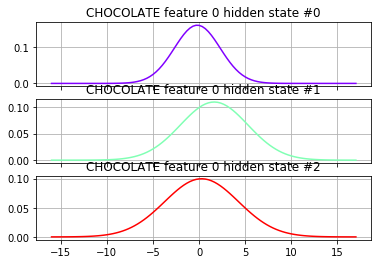

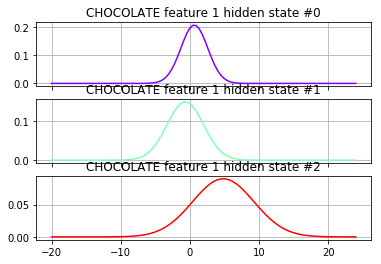

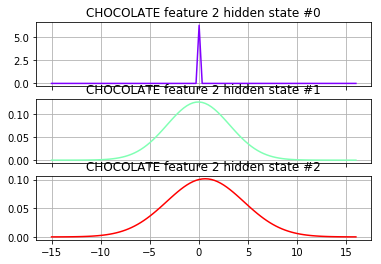

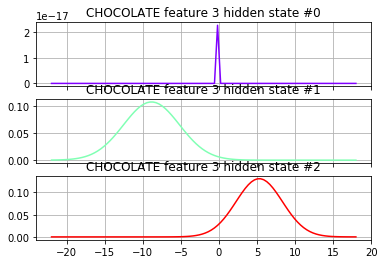

In [28]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [29]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'FISH' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for FISH is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [30]:
from sklearn.model_selection import KFold

training = asl.build_training(features_norm) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
#print(word_sequences)
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [31]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [32]:
# TODO: Implement SelectorCV in my_model_selector.py
%load_ext autoreload
%autoreload 2

from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state=14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 11 states with time 0.7969264570128871 seconds
Training complete for BOOK with 6 states with time 5.766494025010616 seconds
Training complete for VEGETABLE with 2 states with time 2.2095283990056487 seconds
Training complete for FUTURE with 2 states with time 5.271939098005532 seconds
Training complete for JOHN with 12 states with time 60.04147908498999 seconds


In [33]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
%load_ext autoreload
%autoreload 2

from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state=14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Training complete for FISH with 5 states with time 0.5327585319901118 seconds
Training complete for BOOK with 8 states with time 2.9897695160034345 seconds
Training complete for VEGETABLE with 9 states with time 1.0576528430101462 seconds
Training complete for FUTURE with 9 states with time 3.1648682310042204 seconds
Training complete for JOHN with 13 states with time 27.1895528340101 seconds


In [34]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state=14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

# Training complete for FISH with 3 states with time 1.1686174780006695 seconds
# Training complete for BOOK with 15 states with time 5.680475574001321 seconds
# Training complete for VEGETABLE with 15 states with time 4.188679099002911 seconds
# Training complete for FUTURE with 15 states with time 5.388806481001666 seconds
# Training complete for JOHN with 15 states with time 28.78554731499753 seconds

Training complete for FISH with 3 states with time 1.3867159090004861 seconds
Training complete for BOOK with 15 states with time 5.57528004499909 seconds
Training complete for VEGETABLE with 15 states with time 4.427838026997051 seconds
Training complete for FUTURE with 15 states with time 6.084797979987343 seconds
Training complete for JOHN with 15 states with time 31.26430395198986 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

SelectorCV uses Cross Validation folds to split the data set into multiple different training and testing sets, then averaging the log likelihood of all sets. The result is a more accurate idea of how the model will perform on unseen data than simply checking the same data used to build the model. Its time to calculate scales with the number of KFolds necessary, while too many folds could potentially fail to reward good generalization.

BIC or Bayesian information criterion, penalizes models with complexity in particular the number of parameters to approximate the posterior probabilities. In addition it is much faster to calculate since the formula only requires variables which are already known. 

DIC or Deviance information criterion, attempts to rate models based on the difference between their log likelihood scores and the average score across the anti evidence. By maximising the evidence and minimising the anti evidence the model chosen should be accurate and have a low rate of false positives.
Depending on the size of the data set, calculating the anti evidence can be quite time consuming.

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [35]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 72.687s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [36]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [37]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [38]:
%load_ext autoreload
%autoreload 2

# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

# TODO Choose a feature set and model selector
features = features_ground # change as needed
model_selector = SelectorConstant # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

**** WER = 0.6685393258426966
Total correct: 59 out of 178
Video  Recognized                                                    Correct
    2: *GO WRITE *ARRIVE                                             JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *GO1 *IX CAN                                   JOHN CAN GO CAN
   12: JOHN *HAVE *WHAT CAN                                          JOHN CAN GO CAN
   21: JOHN *HOMEWORK *NEW *PREFER *CAR *CAR *FUTURE *EAT            JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *FRANK *TELL *LOVE *TELL *LOVE                                JOHN LIKE IX IX IX
   28: *FRANK *TELL *LOVE *TELL *LOVE                                JOHN LIKE IX IX IX
   30: *SHOULD LIKE *GO *GO *GO                                      JOHN LIKE IX IX IX
   36: *VISIT VEGETABLE *YESTERDAY *GIVE *MARY *MARY                 MARY VEGETABLE KNOW IX LIKE CORN1
   40: *SUE *GIVE *CORN *VEGETABLE *GO   

In [39]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method

all_features = [features_ground, features_norm, features_polar, features_delta]
names_features = ['features_ground', 'features_norm', 'features_polar', 'features_delta']
model_selectors = [SelectorCV, SelectorBIC, SelectorDIC]
selector_names = ['SelectorCV', 'SelectorBIC', 'SelectorDIC']

# TODO Recognize the test set and display the result with the show_errors method
for feature_idx, feature_set in enumerate(all_features):
    for selector_idx, model_selector in enumerate(model_selectors):
        start = timeit.default_timer()
        models = train_all_words(feature_set, model_selector)
        test_set = asl.build_test(feature_set)
        probabilities, guesses = recognize(models, test_set)
        end = timeit.default_timer() - start
        print(f'{names_features[feature_idx]} {selector_names[selector_idx]} in {end} seconds')
        show_errors(guesses, test_set, short=True)
        print('\n')

features_ground SelectorCV in 160.0786484489945 seconds

**** WER = 0.5337078651685393
Total correct: 83 out of 178


features_ground SelectorBIC in 90.93588310699852 seconds

**** WER = 0.550561797752809
Total correct: 80 out of 178


features_ground SelectorDIC in 270.5412421469955 seconds

**** WER = 0.5730337078651685
Total correct: 76 out of 178


features_norm SelectorCV in 199.50034927300294 seconds

**** WER = 0.5898876404494382
Total correct: 73 out of 178


features_norm SelectorBIC in 106.90185184100119 seconds

**** WER = 0.6123595505617978
Total correct: 69 out of 178


features_norm SelectorDIC in 273.304984153001 seconds

**** WER = 0.5955056179775281
Total correct: 72 out of 178


features_polar SelectorCV in 176.5529682769993 seconds

**** WER = 0.5674157303370787
Total correct: 77 out of 178


features_polar SelectorBIC in 104.54679734699312 seconds

**** WER = 0.5449438202247191
Total correct: 81 out of 178


features_polar SelectorDIC in 275.5706356860028 seconds

*

In [40]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method

# features_ground SelectorCV in 163.83773794700028 seconds
# **** WER = 0.5337078651685393
# Total correct: 83 out of 178

# features_ground SelectorBIC in 92.56377709500157 seconds
# **** WER = 0.550561797752809
# Total correct: 80 out of 178

# features_ground SelectorDIC in 257.53987565600255 seconds
# **** WER = 0.5730337078651685
# Total correct: 76 out of 178

# features_norm SelectorCV in 179.7795833759992 seconds
# **** WER = 0.5898876404494382
# Total correct: 73 out of 178

# features_norm SelectorBIC in 89.84669804299847 seconds
# **** WER = 0.6123595505617978
# Total correct: 69 out of 178

# features_norm SelectorDIC in 282.46542226900056 seconds
# **** WER = 0.5955056179775281
# Total correct: 72 out of 178

# features_polar SelectorCV in 181.45353307999903 seconds
# **** WER = 0.5674157303370787
# Total correct: 77 out of 178

# features_polar SelectorBIC in 104.71394099800091 seconds
# **** WER = 0.5449438202247191
# Total correct: 81 out of 178

# features_polar SelectorDIC in 284.3083667409992 seconds
# **** WER = 0.5449438202247191
# Total correct: 81 out of 178

# features_delta SelectorCV in 235.1471823969987 seconds
# **** WER = 0.6348314606741573
# Total correct: 65 out of 178

# features_delta SelectorBIC in 129.87165026300136 seconds
# **** WER = 0.601123595505618
# Total correct: 71 out of 178

# features_delta SelectorDIC in 286.7942691110002 seconds
# **** WER = 0.6235955056179775
# Total correct: 67 out of 178

In [41]:
new_features = [features_scale, features_delta_scale, features_polar_scale, features_polar_norm, features_polar_scale_diff, features_polar_scale_diff_delta]
names_features = ['features_scale', 'features_delta_scale', 'features_polar_scale', 'features_polar_norm', 'features_polar_scale_diff', 'features_polar_scale_diff_delta']
model_selectors = [SelectorCV, SelectorBIC, SelectorDIC]
selector_names = ['SelectorCV', 'SelectorBIC', 'SelectorDIC']

# TODO Recognize the test set and display the result with the show_errors method
for feature_idx, feature_set in enumerate(new_features):
    for selector_idx, model_selector in enumerate(model_selectors):
        start = timeit.default_timer()
        models = train_all_words(feature_set, model_selector)
        test_set = asl.build_test(feature_set)
        probabilities, guesses = recognize(models, test_set)
        end = timeit.default_timer() - start
        print(f'{names_features[feature_idx]} {selector_names[selector_idx]} in {end} seconds')
        show_errors(guesses, test_set, short=True)
        print('\n')

In [42]:
# features_scale SelectorCV in 179.69220569800018 seconds

# **** WER = 0.5674157303370787
# Total correct: 77 out of 178


# features_scale SelectorBIC in 92.94431864400008 seconds

# **** WER = 0.5842696629213483
# Total correct: 74 out of 178


# features_scale SelectorDIC in 268.32906491100016 seconds

# **** WER = 0.5561797752808989
# Total correct: 79 out of 178


# features_delta_scale SelectorCV in 165.2451469680002 seconds

# **** WER = 0.5168539325842697
# Total correct: 86 out of 178


# features_delta_scale SelectorBIC in 93.55489072 seconds

# **** WER = 0.5449438202247191
# Total correct: 81 out of 178


# features_delta_scale SelectorDIC in 267.83853616500005 seconds

# **** WER = 0.5449438202247191
# Total correct: 81 out of 178


# features_polar_scale SelectorCV in 18.832313753999642 seconds

# **** WER = 0.8314606741573034
# Total correct: 30 out of 178


# features_polar_scale SelectorBIC in 15.488588455000354 seconds

# **** WER = 0.8314606741573034
# Total correct: 30 out of 178


# features_polar_scale SelectorDIC in 15.453935098999864 seconds

# **** WER = 0.8314606741573034
# Total correct: 30 out of 178


# features_polar_norm SelectorCV in 177.13014139300003 seconds

# **** WER = 0.6179775280898876
# Total correct: 68 out of 178


# features_polar_norm SelectorBIC in 97.28063895800005 seconds

# **** WER = 0.5955056179775281
# Total correct: 72 out of 178


# features_polar_norm SelectorDIC in 275.7535377100003 seconds

# **** WER = 0.5730337078651685
# Total correct: 76 out of 178


# features_polar_scale_diff SelectorCV in 222.99059110300004 seconds

# **** WER = 0.7247191011235955
# Total correct: 49 out of 178


# features_polar_scale_diff SelectorBIC in 107.95954800999971 seconds

# **** WER = 0.7640449438202247
# Total correct: 42 out of 178


# features_polar_scale_diff SelectorDIC in 281.6946648809999 seconds

# **** WER = 0.7078651685393258
# Total correct: 52 out of 178


# features_polar_scale_diff_delta SelectorCV in 252.3127657199998 seconds

# **** WER = 0.6685393258426966
# Total correct: 59 out of 178


# features_polar_scale_diff_delta SelectorBIC in 126.35159485399981 seconds

# **** WER = 0.7078651685393258
# Total correct: 52 out of 178


# features_polar_scale_diff_delta SelectorDIC in 300.50953822600013 seconds

# **** WER = 0.6235955056179775
# Total correct: 67 out of 178


In [43]:
feature_set = features_ground + features_norm + features_polar + features_delta
model_selector = SelectorCV
start = timeit.default_timer()
models = train_all_words(feature_set, model_selector)
test_set = asl.build_test(feature_set)
probabilities, guesses = recognize(models, test_set)
end = timeit.default_timer() - start
print(f'4 features with SelectorCV in {end} seconds')
show_errors(guesses, test_set, short=True)
print('\n')

4 features with SelectorCV in 192.85549431599793 seconds

**** WER = 0.5337078651685393
Total correct: 83 out of 178




In [45]:
feature_set = features_ground + features_norm + features_polar + features_delta
model_selector = SelectorBIC
start = timeit.default_timer()
models = train_all_words(feature_set, model_selector)
test_set = asl.build_test(feature_set)
probabilities, guesses = recognize(models, test_set)
end = timeit.default_timer() - start
print(f'4 features with SelectorBIC in {end} seconds')
show_errors(guesses, test_set, short=True)
print('\n')

4 features with SelectorBIC in 126.27898304098926 seconds

**** WER = 0.47752808988764045
Total correct: 93 out of 178




In [46]:
feature_set = features_ground + features_norm + features_polar + features_delta
model_selector = SelectorDIC
start = timeit.default_timer()
models = train_all_words(feature_set, model_selector)
test_set = asl.build_test(feature_set)
probabilities, guesses = recognize(models, test_set)
end = timeit.default_timer() - start
print(f'4 features with SelectorDIC in {end} seconds')
show_errors(guesses, test_set, short=True)
print('\n')

4 features with SelectorDIC in 267.41922565200366 seconds

**** WER = 0.5280898876404494
Total correct: 84 out of 178




In [47]:
feature_set = features_scale
model_selector = SelectorBIC
start = timeit.default_timer()
models = train_all_words(feature_set, model_selector)
test_set = asl.build_test(feature_set)
probabilities, guesses = recognize(models, test_set)
end = timeit.default_timer() - start
print(f'features_scale with SelectorBIC in {end} seconds')
show_errors(guesses, test_set, short=True)
print('\n')

features_scale with SelectorBIC in 87.1936401839921 seconds

**** WER = 0.5842696629213483
Total correct: 74 out of 178




In [48]:
feature_set = features_ground + features_norm + features_polar + features_delta + features_scale + features_delta_scale + features_polar_scale + features_polar_norm + features_polar_scale_diff + features_polar_scale_diff_delta
model_selector = SelectorBIC
start = timeit.default_timer()
models = train_all_words(feature_set, model_selector)
test_set = asl.build_test(feature_set)
probabilities, guesses = recognize(models, test_set)
end = timeit.default_timer() - start
print(f'all features with SelectorBIC in {end} seconds')
show_errors(guesses, test_set, short=True)
print('\n')

all features with SelectorBIC in 102.64179495700228 seconds

**** WER = 0.8314606741573034
Total correct: 30 out of 178




In [49]:
feature_set = features_polar_norm + features_delta_scale + features_scale
model_selector = SelectorBIC
start = timeit.default_timer()
models = train_all_words(feature_set, model_selector)
test_set = asl.build_test(feature_set)
probabilities, guesses = recognize(models, test_set)
end = timeit.default_timer() - start
print(f'three new features with SelectorBIC in {end} seconds')
show_errors(guesses, test_set, short=True)
print('\n')

three new features with SelectorBIC in 108.47613012700458 seconds

**** WER = 0.5393258426966292
Total correct: 82 out of 178




In [50]:
feature_set = features_ground + features_norm + features_polar + features_delta_scale
# features_delta_scale is better than features_delta
model_selector = SelectorBIC
start = timeit.default_timer()
models = train_all_words(feature_set, model_selector)
test_set = asl.build_test(feature_set)
probabilities, guesses = recognize(models, test_set)
end = timeit.default_timer() - start
print(f'4 features with SelectorBIC in {end} seconds')
show_errors(guesses, test_set, short=True)
print('\n')

# ground, norm, polar, delta_scale
# **** WER = 0.4550561797752809
# Total correct: 97 out of 178

# ground, norm, polar_norm, delta_scale
# **** WER = 0.4943820224719101
# Total correct: 90 out of 178

4 features with SelectorBIC in 109.62327036699571 seconds

**** WER = 0.4550561797752809
Total correct: 97 out of 178




In [51]:
feature_set = features_ground + features_norm + features_polar + features_delta_scale
model_selectors = [SelectorCV, SelectorBIC, SelectorDIC]
selector_names = ['SelectorCV', 'SelectorBIC', 'SelectorDIC']

# TODO Recognize the test set and display the result with the show_errors method
for selector_idx, model_selector in enumerate(model_selectors):    
    model_selector = model_selectors[selector_idx]
    start = timeit.default_timer()
    models = train_all_words(feature_set, model_selector)
    test_set = asl.build_test(feature_set)
    probabilities, guesses = recognize(models, test_set)
    end = timeit.default_timer() - start
    print(f'4 features {selector_names[selector_idx]} in {end} seconds')
    show_errors(guesses, test_set, short=True)
    print('\n')

4 features SelectorCV in 171.38144103401282 seconds

**** WER = 0.47752808988764045
Total correct: 93 out of 178


4 features SelectorBIC in 110.029319475987 seconds

**** WER = 0.4550561797752809
Total correct: 97 out of 178


4 features SelectorDIC in 259.7781580699957 seconds

**** WER = 0.4887640449438202
Total correct: 91 out of 178




In [52]:
feature_set = features_ground + features_norm + features_polar + features_delta_scale
model_selectors = [SelectorBIC]
selector_names = ['SelectorBIC']

# TODO Recognize the test set and display the result with the show_errors method
for selector_idx, model_selector in enumerate(model_selectors):    
    model_selector = model_selectors[selector_idx]
    start = timeit.default_timer()
    models = train_all_words(feature_set, model_selector)
    test_set = asl.build_test(feature_set)
    probabilities, guesses = recognize(models, test_set)
    end = timeit.default_timer() - start
    print(f'4 best features {selector_names[selector_idx]} in {end} seconds')
    show_errors(guesses, test_set, short=False)
    print('\n')

4 best features SelectorBIC in 110.53751238899713 seconds

**** WER = 0.4550561797752809
Total correct: 97 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE GO CAN                                           JOHN CAN GO CAN
   12: JOHN *WHAT *WHAT CAN                                          JOHN CAN GO CAN
   21: JOHN *NEW *JOHN *MARY *CAR *CAR *FUTURE *FUTURE               JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX *LOVE IX IX                                          JOHN LIKE IX IX IX
   28: JOHN *MARY IX IX IX                                           JOHN LIKE IX IX IX
   30: JOHN LIKE IX IX IX                                            JOHN LIKE IX IX IX
   36: MARY *VISIT *GIVE IX *GO *MARY                                MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *CORN MARY *IX                                        JO

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**
I tested the combination of all three selectors and the original four features.
The WER scores ranged from 0.533 to 0.634, with the best scores found with SelectorCV or SelectorBIC. The best single original feature seemed to be the features_ground, followed by the features_polar. When it came to selector speed, the SelectorBIC was approximately two times faster than SelectorCV and up to three times faster than SelectorDIC.

While testing feature combinations and new features I mostly used the SelectorBIC because of its good and fast results.

Next I tried to combine several features together to see what impact that had on the WER score.

All four original features together with the SelectorBIC provided the best score so far which was 0.477.

I then tested all my additional custom features looking to see if any of them alone were effective.

The two best were features_delta_scale with SelectorCV at 0.516 WER and features_scale with SelectorDIC at 0.556 WER.

I initially tried to add some of these new features to the existing four but the scores always suffered. Perhaps this was the BIC selector feature complexity penalty coming into affect, or simply that the features were muddying the difference between words.

Once I realised that adding features wasn't going to help, I decided to try substituting features with some of the new ones I had created. In the end I saw a minor improvement by swapping features_delta with features_delta_scale getting the score down to 0.455 WER.

The final combination was:
features_ground + features_norm + features_polar + features_delta_scale

Interestingly delta_scale is not a scaled version of the features_delta which is based on the features_ground, but rather its based on features_scale which is a scaling of the original left and right x,y values.

Other substitutions didn't seem to yield beneficial results.

Finding the best features could be improved by automating the process of checking different combinations and comparing them after processing is done. Alternatively something like PCA (principal component analysis) might assist in determining which features are contributing to the accuracy the most.

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [53]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 39.245s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [54]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,-7705.601616,-5.956598e+05,-6050.334288,-879.761332,-36323.480984,-759.621705,-11222.660812,-1879.023493,-25222.330412,-1149.220569,...,-4155.593113,-660.121962,-2751.840456,-1567.083050,-655.410092,-8218.631951,-1690.212925,-1407.056670,-536.991853,-651.603534
1,-19259.175028,-5.845157e+05,-9228.351886,-293.672909,-243970.374961,-381.847665,-10396.935054,-236.532384,-9951.875492,-834.368943,...,-657.674342,-1155.145961,-3279.514911,-1159.474768,-928.622184,-18949.933699,-754.981055,-1415.752239,-117.251162,-1596.370111
2,-28580.301709,-2.448877e+06,-17228.875082,-657.251168,-348651.625977,-938.663882,-24041.100096,-1734.484502,-13665.878804,-1583.254267,...,-3386.531589,-1645.438520,-5453.116562,-2492.247993,-2984.947584,-29081.914437,-2316.330873,-2452.393357,-1315.298038,-1942.403497
3,-3785.711028,-5.542399e+06,-1751.824407,-660.954839,-5029.213466,-974.146128,-2748.053099,-2631.339665,-118841.373786,-1574.867975,...,-7823.838506,-451.702956,-7505.190362,-1992.976187,-2375.235791,-36714.621985,-613.779745,-1647.251542,-3803.117669,-1465.255973
4,-6148.626998,-2.657050e+06,-1952.022313,-169.375252,-44839.230884,-163.031271,-573.838102,-333.114123,-3900.199403,-125.412826,...,-538.412989,-152.447444,-1006.299072,-185.830550,-2371.739105,-17336.167841,-414.729404,-1137.616987,-1333.199825,-589.186707


In [68]:
def scale_probabilities(probabilities):
    clean_probabilties = dict((word,score) for word, score in probabilities.items() if score > float('-inf'))
    scores = [score for word, score in clean_probabilties.items()]
    
    minimum = min(scores)
    maximum = max(scores)
    diff = maximum - minimum
    
    # norm = (original value - mean) / standard deviation
    norm_probabilities = {}
    for word, score in clean_probabilties.items():
        norm_probabilities[word] = (clean_probabilties[word] - minimum) / diff

    return norm_probabilities

In [69]:
def normalize_probabilities(probabilities):
    # standard score (z score) = (X - μ) / σ

    # calculate mean
    clean_probabilties = dict((word,score) for word, score in probabilities.items() if score > float('-inf'))
    scores = [score for word, score in clean_probabilties.items()]
    
    mean = np.mean(scores)
    std = np.std(scores)
    
    # calculate standard score
    norm_probabilities = {}
    for word, score in clean_probabilties.items():
        norm_probabilities[word] = (clean_probabilties[word] - mean) / std

    return norm_probabilities

In [107]:
sentence_list = [[idx] * len(test_set.sentences_index[idx]) for idx in test_set.sentences_index]
print(len(sentence_list))
print(sentence_list)

40
[[2, 2, 2], [7, 7, 7, 7], [12, 12, 12, 12], [21, 21, 21, 21, 21, 21, 21, 21], [25, 25, 25, 25, 25], [28, 28, 28, 28, 28], [30, 30, 30, 30, 30], [36, 36, 36, 36, 36, 36], [40, 40, 40, 40, 40], [43, 43, 43, 43], [50, 50, 50, 50, 50], [54, 54, 54, 54, 54], [57, 57, 57, 57], [67, 67, 67, 67, 67], [71, 71, 71, 71], [74, 74, 74, 74], [77, 77, 77], [84, 84, 84, 84], [89, 89, 89, 89, 89, 89, 89], [90, 90, 90, 90, 90, 90], [92, 92, 92, 92, 92, 92], [100, 100, 100, 100], [105, 105], [107, 107, 107, 107, 107], [108, 108], [113, 113, 113, 113, 113], [119, 119, 119, 119, 119], [122, 122, 122], [139, 139, 139, 139, 139], [142, 142, 142, 142, 142], [158, 158, 158], [167, 167, 167, 167, 167], [171, 171, 171], [174, 174, 174, 174, 174], [181, 181], [184, 184, 184, 184, 184], [189, 189, 189, 189], [193, 193, 193, 193], [199, 199, 199], [201, 201, 201, 201, 201, 201]]


In [112]:
%load_ext autoreload
%autoreload 2

import arpa
import kenlm
import itertools

three_arpa_models = arpa.loadf('data/ukn.3.lm')
lm_three = three_arpa_models[0]  # ARPA files may contain several models.

master_idx = -1
new_guesses = []
verbose = True
for sidx, sentence_words in enumerate(sentence_list):
    start = timeit.default_timer()
#    if sidx < 2:
    if True:
        sentence_probs = []
        sentence_candidates = []
        sentence_scores = []
        for idx, video_id in enumerate(sentence_words):
            master_idx += 1
            old_probs = probabilities[master_idx]
            norm_probs = normalize_probabilities(old_probs)
            scale_probs = scale_probabilities(old_probs)
            candidates = [(score, word) for word, score in old_probs.items()]
            candidates = sorted(candidates)[::-1]
            old_best_score, old_word = candidates[0]
            cut_off = old_best_score * 3
            candidates = [(score, word) for score, word in candidates if score >= cut_off]
            candidates = candidates[:num_best]
            candidates = [word.rstrip('123456789') for score, word in candidates]
            candidates = candidates[:3] # keep no more than 3
            if verbose:
                print(f'{idx} candidates {candidates}')
            sentence_probs.append((norm_probs, scale_probs, old_probs))
            if len(candidates) < 1:
                candidates.append(old_word)
            sentence_candidates.append(candidates)
        combinations = itertools.product(*sentence_candidates)
        num_sentences = 0
        for sentence in combinations:
            num_sentences += 1
            org_logl = 0
            lm_score = 0
            norm_score = 0
            for i in range(len(sentence)):
                word = sentence[i]
                norm_score += sentence_probs[i][0][word]
#                 org_logl += sentence_probs[i][2][word]
#                 lm_score += lm_three.log_p(sentence[:i + 1])
#                 lm_score += lm_three.log_s(sentence[:i + 1])
            lm_score += lm_three.log_s(sentence)

            new_score = (norm_score / len(sentence)) + lm_score * 10
            if verbose:
                print(f'sentence {sentence} {org_logl} {lm_score} {new_score}')
            
            sentence_scores.append((new_score, sentence, org_logl, lm_score))
        best_sentence = max(sentence_scores)
        if verbose:
            print(f'Best sentence {best_sentence}')
            print('\n\n')
        new_guesses += best_sentence[1]
        end = timeit.default_timer() - start
        if verbose:
            print(f'num_sentences {num_sentences} {end} seconds')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0 candidates ['JOHN', 'NOT', 'FUTURE']
1 candidates ['WRITE', 'BOOK', 'BROTHER']
2 candidates ['ARRIVE', 'JOHN', 'NEW']
sentence ('JOHN', 'WRITE', 'ARRIVE') 0 -4.999848099999994 -49.8118874121372
sentence ('JOHN', 'WRITE', 'JOHN') 0 -5.598988200000008 -55.80329030663219
sentence ('JOHN', 'WRITE', 'NEW') 0 -6.304562899999993 -62.85903848939415
sentence ('JOHN', 'BOOK', 'ARRIVE') 0 -5.363856599999991 -53.451976712239684
sentence ('JOHN', 'BOOK', 'JOHN') 0 -5.962996700000005 -59.44337960673467
sentence ('JOHN', 'BOOK', 'NEW') 0 -6.6685713999999905 -66.49912778949664
sentence ('JOHN', 'BROTHER', 'ARRIVE') 0 -3.01913506999999 -30.0047614633173
sentence ('JOHN', 'BROTHER', 'JOHN') 0 -5.828014199999998 -58.093554657812234
sentence ('JOHN', 'BROTHER', 'NEW') 0 -6.533588899999998 -65.14930284057434
sentence ('NOT', 'WRITE', 'ARRIVE') 0 -7.788773999999989 -77.70116196675934
sentence ('NOT', 'WRITE', 'JOHN') 0

In [113]:
show_errors(new_guesses, test_set)


**** WER = 0.4887640449438202
Total correct: 91 out of 178
Video  Recognized                                                    Correct
    2: JOHN *BROTHER *ARRIVE                                         JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE GO CAN                                           JOHN CAN GO CAN
   12: JOHN *WHAT GO CAN                                             JOHN CAN GO CAN
   21: JOHN *ARRIVE *JOHN *MARY *NEW *CAR *FUTURE *MARY              JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX IX IX                                             JOHN LIKE IX IX IX
   28: JOHN *IX IX IX IX                                             JOHN LIKE IX IX IX
   30: JOHN LIKE IX IX IX                                            JOHN LIKE IX IX IX
   36: *JOHN *MARY *IX IX *IX *IX                                    MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *CORN MARY LOVE                                       JOHN IX THINK MARY LOVE
   43: JOHN *FUTURE BUY HOUSE       

I attempted to integrate the results of the 3gram ARPA model with the existing HMM model however the results were lacklustre.

I believe that either my original models are have been overfit and or I do not have the correct way to combine the results from the ARPA LM with the existing results. I tried several different methods including, multiplying, scoring the different ngrams of the sentence and even tried the bigram model as well.

One problem is generating the product of the sentence possibilities gets really large with some of the sentences like the one with 8 words in it. For the moment I have limited the number of candidate words per sentence position to 3, but a more optimal solution would attempt to allow more but restrict them once a certain number was reached, or used an alternative heuristic to determine which ones to pick.

Unfortunately I didn't have more time to explore possible solutions or improvements but I learnt a lot and it was fun to see the NLP results along side the HMM results.